In [1]:
# importing libraries and dependencies
import re
import string
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from num2words import num2words
from spellchecker import SpellChecker
from sklearn.preprocessing import OneHotEncoder
from gensim.models import Word2Vec
import gensim.downloader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
import pickle
import warnings
# ML models
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
# Supress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)


from sklearn.preprocessing import OneHotEncoder


from nltk import ne_chunk, pos_tag, word_tokenize, sent_tokenize
from nltk.tree import Tree

from wordcloud import WordCloud
from venn import venn, pseudovenn

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, accuracy_score, f1_score, 
                             roc_auc_score, average_precision_score, 
                             recall_score, hamming_loss)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA  # corrected import statement

# Miscellaneous utilities
from scipy import sparse as sp_sparse
from itertools import combinations
from tqdm.notebook import tqdm  # for progress bars
import os
import random
from collections import Counter


In [2]:
data = pd.read_csv('/Users/chkapsalis/Desktop/working/di/sat_studying/reviews.csv', index_col=None, header=0, sep=',', encoding='utf-8')

In [3]:
data.head()


sentiment                                             review
0  Positive  With all this stuff going down at the moment w...
1  Positive  'The Classic War of the Worlds' by Timothy Hin...
2  Negative  The film starts with a manager (Nicholas Bell)...
3  Negative  It must be assumed that those who praised this...
4  Positive  Superbly trashy and wondrously unpretentious 8...

In [36]:
print('Dimensions of train_df:', data.shape)

Dimensions of train_df: (25000, 2)


In [37]:
## Initital observations on the dataset
# remove duplicates\
train_df.drop_duplicates().shape[0] == data.shape[0]

False

In [38]:
# There are duplicate values, so I proceed to show their number and drop them
print(data.shape[0] - data.drop_duplicates().shape[0])
train_df.drop_duplicates(inplace=True)

96


In [39]:
# inspecting the existence of missing values
for col in data.columns:
    print(f'Number of NAs in {col}:', sum(data[col].isna()))

Number of NAs in sentiment: 0
Number of NAs in review: 0


In [5]:
# Initialize objects necessary for pre-processing 

spell = SpellChecker()
wl = WordNetLemmatizer()

custom_stopwords = ["mr", "mrs", "miss", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten",
                    "us", "also", "dont", "cant", "any", "can", "along", "among", "during", "anyone",
                    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z",
                    "hi", "hello", "hey", "ok", "okay", "lol", "rofl", "hola", "let", "may", "etc"]


emojis_pattern = re.compile("["
		u"\U0001F600-\U0001F64F"  # emoticons 
		u"\U0001F300-\U0001F5FF"  # symbols & pictographs 
		u"\U0001F680-\U0001F6FF"  # transport & map symbols 
		u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
		u"\U00002702-\U000027B0"
		u"\U000024C2-\U0001F251"
	"]", 
	flags=re.UNICODE)
emoticons_pattern = re.compile(u'(' + u'|'.join(re.escape(k) for k in sorted(EMOTICONS_EMO.keys(), key=len, reverse=True)) + u')', 
	flags=re.UNICODE)
sequencePattern   = r"(.)\1\1+"  # this 'catches' the occurrence of triplets, quintets, etc of single characters, e.g. kkk, hhhh, zzzzz, 111111
seqReplacePattern = r"\1\1"  # maps the character matched by the sequencePattern (the one that got 'caught' using '.') to a double occurrence, e.g. 666 -> 66 
contractions_dict = {
	"ain't": "are_not", 
	"'s": "is",
	"aren't": "are not",
    "isn't": "is not", 
	"can't": "cannot",
    "can't've": "cannot have",
	"'cause": "because",
	"could've": "could have",
	"couldn't": "could not",
	"couldn't've": "could not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
	"didn't": "did not",
	"doesn't": "does not",
	"don't": "do not",
    "wasn't": "was not",
    "weren't": "were not",
	"hadn't": "had not",
	"hadn't've": "had not have",
	"hasn't": "has not",
	"haven't": "have not",
	"he'd": "he would",
	"he'd've": "he would have",
	"he'll": "he will",
	"he'll've": "he will have",
	"how'd": "how did",
	"how'd'y": "how do you",
	"how'll": "how will",
    "i've": "I have",
	"i'd": "I would",  # since casting to lower-case typically preceeds the step of contraction fixing
	"i'd've": "I would have",
	"i'll": "I will",
	"y'all'd've": "you all would have",
	"y'all're": "you all are",
	"y'all've": "you all have",
	"you'd": "you would",
	"you'd've": "you would have",
	"you'll": "you will",
	"you'll've": "you will have",
	"you're": "you are",
	"you've": "you have"
}
contractions_pattern = re.compile(u'(' + u'|'.join(k for k in sorted(contractions_dict.keys(), key=len, reverse=True)) + u')', flags=re.UNICODE)

stop_words = set(stopwords.words('english')).union(set(custom_stopwords))


# Regex patterns for removing special characters, URLs, HTML tags, etc.
special_chars_pattern = re.compile(r"[" + ''.join([re.escape(c) for c in ['\\', '/', '\n', '\t']]) + "]")
links_pattern = re.compile(r'https?://\S+|www\.\S+')
html_tags_pattern = re.compile(r'<.*?>')
digits_pattern = re.compile(r'\d')
punctuation_pattern = re.compile(r"[" + ''.join([re.escape(c) for c in set(string.punctuation)]) + "]")
extra_spaces_pattern = re.compile(r' {2,}')  #or re.compile(r'(\s)\1+') for ALL whitespace redundancy
repeated_chars_pattern = re.compile(r'(.)\1\1+')  # 3 or more, because otherwise i could have stupid shit like 'all' turned into 'al'
emojis_pattern = re.compile("[" u"\U0001F600-\U0001F64F"
                                u"\U0001F300-\U0001F5FF"
                                u"\U0001F680-\U0001F6FF"
                                u"\U0001F1E0-\U0001F1FF"
                                u"\u2600-\u26FF\u2700-\u27BF" "]", flags=re.UNICODE)
small_words_pattern = re.compile(r'\b\w{1,2}\b')

# special preprocessing functions

# function to replace emoticons
def replace_emoticons(match):
    emoticon = match.group(0)  # retrieve the matched emoticon 
    return "_".join(EMOTICONS_EMO[emoticon].replace(",", " ").split())  # Return the corresponding text equivalent from the dictionary
    # the replace & split are needed because some emoticons/emojis correspond to multiple words
# function to replace emojis
def replace_emojis(match):
    emoji = match.group(0)  # retrieve the matched emoticon 
    return "_".join(UNICODE_EMOJI[emoji].replace(",", " ").replace(":"," ").split())  # Return the corresponding text equivalent from the dictionary
# function to replace contractions
def replace_contractions(match):
	contr = match.group(0)
	return contractions_dict[contr]

def convert_to_lower_case(text):    
    return (lambda x: x.lower() if isinstance(x, str) else x)(text)

def remove_escape_char(text):
    """function to remove newline (\n),
    tab(\t) and slashes (/ , \) from the input text"""
    return re.sub(rspecial_chars_pattern,' ', text)  # the replacement expression cannot be compiled

def remove_html_tags(text):
    """function to remove html tags (< >) and its content from the input text"""
    return re.sub(html_tags_pattern," ", text)  # if i did not want to remove the contents of the html tags (i.e. whatever
    # is between an opening and a closing tag, I would do <.*?> to disable the greediness of the compiler)

def remove_links(text):
    """function to remove any kind of links with no html tags"""
    return re.sub(links_pattern,' ', text)

def remove_digits(text):
    """function to remove digits from the input text"""
    return re.sub(digits_pattern,' ',text)

def remove_punctuation(text):
    return re.sub(punctuation_pattern, ' ', text)

def remove_extra_spaces_if_any(text):
    """function to remove extra spaces if any after all the pre-preocessing"""
    return re.sub(extra_spaces_pattern, ' ', text)
# if it was about extra whitespace in general, I would do re.sub(re.compile('\s\1+'),'\1',text)

def remove_repeated_characters(text):
    #on close observation of toxic comments, In some of the bad comments, words in 
    #bad words characters are repeated. say for example...
    #the word "shit" is written as SSSSHHHHHHHHIIIIIIIIIIITTTTTT
    #but the base word is "shit", in order to increase model performance
    # i am adding this.
    
    """function to remove repeated characters if any from the input text"""

    """for example CAAAAASSSSSSEEEEE SSSSTTTTTUUUUUUDDDDYYYYYY gives CASE STUDY"""

    return re.sub(repeated_chars_pattern, r'\1', text)

def remove_small_words(text):
    """function to remove words with length less than 2"""
    return re.sub(small_words_pattern, ' ', text)  # i expect actual words to contain only letters - digits will have been removed
    # earlier on anyways

# further steps to take
# if i needed to take numbers into account, i could transform them into words -> num2words
# i could also fix any spelling errors to remove ambiguity and give better vector representations to words in my text -> pyspellchecker
def fix_spelling_and_numbers(text):
    words = text.split()
    corrected_words = [spell.correction(word) if word not in spell and spell.correction(word) != None else word for word in words]
    text = ' '.join([num2words(int(word)) if word.isdigit() else word for word in corrected_words])
    return ' '.join(text)

def stopword_removal(s):
    return ' '.join([word for word in s.split() if word not in stop_words])
# for lemmatization, I use nltk, so I need to make sure i use its own pos tags to get the most accurate lemmas
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatizer(s):
    word_pos_tags = nltk.pos_tag(nltk.word_tokenize(s))
    a = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for tag in word_pos_tags]
    return " ".join(a)




In [7]:
def preprocess(text):

    preprocessed_text = []

    for each in tqdm(text):
        each = convert_to_lower_case(each)
        each = each.strip()
        each = remove_html_tags(each)
        each = remove_links(each)
        each = re.sub(contractions_pattern, replace_contractions, each)  # replacing contractions with their text equivalents
        each = re.sub(emoticons_pattern, replace_emoticons, each)  # replacing emoticons with their text equivalents
        each = re.sub(emojis_pattern, replace_emojis, each)  # same for emojis
        each = remove_punctuation(each)
        each = remove_digits(each)    	
        # replacing repetitive sequences of chars with doubles
        each = remove_repeated_characters(each)
        each = remove_small_words(each)
        each = remove_extra_spaces_if_any(each)


        each = stopword_removal(each)
        each = lemmatizer(each)
        
        preprocessed_text.append(each.strip())

    return preprocessed_text



data['clean_text'] = preprocess(data['review'].values)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [252]:
data.to_csv('checkme.csv', index=False, header=True, sep='|', encoding='utf-8')

In [169]:
### More advanced, using NLTK

# Universal POS tags
# The POS tags used by the nltk.pos_tag function are different from the tags used by WordNet, and this mapping 
# ensures that the lemmatizer receives the correct POS tags.
upos_tags = [
    'ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ',
    'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ',
    'SYM', 'VERB', 'X'
]

# NER labels in NLTK
ner_labels_nltk = [
    'PERSON', 'ORGANIZATION', 'LOCATION', 'DATE', 'TIME', 'MONEY', 'PERCENT', 'FACILITY', 'GPE'
]

# Define custom stopwords
custom_stopwords = ["mr", "mrs", "miss", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten",
                    "us", "also", "dont", "cant", "any", "can", "along", "among", "during", "anyone",
                    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z",
                    "hi", "hello", "hey", "ok", "okay", "lol", "rofl", "hola", "let", "may", "etc"]
stop_words = set(stopwords.words('english')).union(custom_stopwords)

# Initialize SpellChecker and Lemmatizer
spell = SpellChecker()
wl = WordNetLemmatizer()

# Regex patterns for removing special characters, URLs, HTML tags, etc.
special_chars_pattern = re.compile("[" + ''.join([re.escape(c) for c in ['\\', '/', '\n', '\t']]) + "]")
links_pattern = re.compile(r'https?://\S+|www\.\S+')
html_tags_pattern = re.compile(r'<.*?>')
digits_pattern = re.compile(r'\d')
punctuation_pattern = re.compile("[" + ''.join([re.escape(c) for c in set(string.punctuation)]) + "]")
extra_spaces_pattern = re.compile(r'(\s)\1+')
repeated_chars_pattern = re.compile(r'(.)\1\1+')
emojis_pattern = re.compile("[" u"\U0001F600-\U0001F64F"
                                u"\U0001F300-\U0001F5FF"
                                u"\U0001F680-\U0001F6FF"
                                u"\U0001F1E0-\U0001F1FF"
                                u"\u2600-\u26FF\u2700-\u27BF" "]", flags=re.UNICODE)

# Contractions dictionary
contractions_dict = {
	"ain't": "are_not", 
	"'s": "is",
	"aren't": "are not",
    "isn't": "is not", 
	"can't": "cannot",
    "can't've": "cannot have",
	"'cause": "because",
	"could've": "could have",
	"couldn't": "could not",
	"couldn't've": "could not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
	"didn't": "did not",
	"doesn't": "does not",
	"don't": "do not",
    "wasn't": "was not",
    "weren't": "were not",
	"hadn't": "had not",
	"hadn't've": "had not have",
	"hasn't": "has not",
	"haven't": "have not",
	"he'd": "he would",
	"he'd've": "he would have",
	"he'll": "he will",
	"he'll've": "he will have",
	"how'd": "how did",
	"how'd'y": "how do you",
	"how'll": "how will",
    "i've": "I have",
	"i'd": "I would",  # since casting to lower-case typically preceeds the step of contraction fixing
	"i'd've": "I would have",
	"i'll": "I will",
	"y'all'd've": "you all would have",
	"y'all're": "you all are",
	"y'all've": "you all have",
	"you'd": "you would",
	"you'd've": "you would have",
	"you'll": "you will",
	"you'll've": "you will have",
	"you're": "you are",
	"you've": "you have"
}
contractions_pattern = re.compile(u'(' + u'|'.join(k for k in sorted(contractions_dict.keys(), key=len, reverse=True)) + u')', flags=re.UNICODE)

def replace_emoticons(match):
    emoticon = match.group(0)
    return "_".join(EMOTICONS_EMO[emoticon].replace(",", "").split())

def replace_emojis(match):
    emoji = match.group(0)
    return "_".join(UNICODE_EMOJI.get(emoji, "unknown_emoji").replace(",", "").replace(":", "").split())

def replace_contractions(match):
    contr = match.group(0)
    return contractions_dict[contr]

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def convert_to_lower_case(text):
    return text.lower() if isinstance(text, str) else text

def remove_special_chars(text):
    return re.sub(special_chars_pattern, ' ', text)

def remove_links(text):
    return re.sub(links_pattern, '', text)

def remove_html_tags(text):
    return re.sub(html_tags_pattern, '', text)

def remove_digits(text):
    return re.sub(digits_pattern, ' ', text)

def remove_punctuation(text):
    return re.sub(punctuation_pattern, ' ', text)

def remove_extra_spaces_if_any(text): # all repeated whitespace will be replaced with a single space character
    return re.sub(extra_spaces_pattern, ' ', text)

def remove_repeated_characters(text):
    return re.sub(repeated_chars_pattern, r'\1', text)

def fix_spelling_and_numbers(text):
    words = text.split()
    corrected_words = [spell.correction(word) if word not in spell and spell.correction(word) != None else word for word in words]
    return ' '.join(corrected_words)

# The POS tags used by the nltk.pos_tag function are different from the tags used by WordNet, and this mapping 
# ensures that the lemmatizer receives the correct POS tags.
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def get_named_entities(tree):
    entities = []
    for subtree in tree:
        if isinstance(subtree, nltk.Tree):
            entity_name = ' '.join([leaf[0] for leaf in subtree.leaves()])
            entity_type = subtree.label()
            if entity_type in ner_labels_nltk:
                entities.append((entity_name, entity_type))
    return entities

def lemmatizer(text):
    lemmatized_words = [wl.lemmatize(word, 'v') for word in text.split()]
    return ' '.join(lemmatized_words)

def preprocess_and_extract_features(text):
    features = {}
    
    # Initial preprocessing steps
    features['uppercase_words'] = sum(1 for word in word_tokenize(text) if word.isupper())  # can't avoid redundant tokenization to count this
    text = convert_to_lower_case(text)
    features['length'] = len(text)
    features['no_of_sentences'] = len(sent_tokenize(text))
    text = remove_html_tags(text)
    text = remove_links(text)
    text = re.sub(emojis_pattern, replace_emojis, text)
    text = re.sub(emoticons_pattern, replace_emoticons, text)
    text = re.sub(contractions_pattern, replace_contractions, text)
    features['new_line'] = text.count('\n')
    features['question_mark'] = text.count('?')
    features['exclamation_mark'] = text.count('!')
    features['at_the_rate_mark'] = text.count('@')
    features['hash'] = text.count('#')
    features['ampercent'] = text.count('&')
    features['star'] = text.count('*')
    features['dot'] = text.count('.')
    
    # Further preprocessing
    text = remove_digits(text)
    text = remove_punctuation(text)
    text = remove_repeated_characters(text)
    text = remove_extra_spaces_if_any(text)
    text = remove_special_chars(text)
    # text = fix_spelling_and_numbers(text)  # spelling takes a long long time, and if i do not ignore numbers it will take too long

    # Tokenize and POS tagging
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens, tagset='universal')  # Use universal tagset

    # Count POS tags
    pos_counts = Counter(tag for word, tag in pos_tags)
    features.update({f'{pos}_instances': pos_counts[pos] for pos in upos_tags})

    # Named Entity Recognition
    named_entities = ne_chunk(pos_tags)
    ner_counts = {label: 0 for label in ner_labels_nltk}
    labels_applied = get_named_entities(named_entities) 
    for entity_name, label in labels_applied:
        ner_counts[label] += 1
    features.update({f'{label}_instances': ner_counts[label] for label in ner_labels_nltk})

    # Final processing
    text = remove_stopwords(text)
    text = lemmatizer(text)

    return text, features

# Initialize lists to store the processed text and extracted features
processed_texts = []
features_list = []

# Process each comment in the DataFrame
for text in tqdm(data['review'], desc="Processing reviews"):
    processed_text, features = preprocess_and_extract_features(text)
    processed_texts.append(processed_text)
    features_list.append(features)

# Create a DataFrame from the extracted features
features_df = pd.DataFrame(features_list)

# Add processed texts to the DataFrame
data['clean_text2'] = processed_texts

# Merge the features DataFrame with the original DataFrame
data.reset_index(inplace=True)
final_df = data.merge(features_df, how='inner', left_index=True, right_index=True)

# Display the final DataFrame
print(final_df.head())


Processing reviews:   0%|          | 0/25000 [00:00<?, ?it/s]

   index sentiment                                             review  \
0      0  Positive  With all this stuff going down at the moment w...   
1      1  Positive  'The Classic War of the Worlds' by Timothy Hin...   
2      2  Negative  The film starts with a manager (Nicholas Bell)...   
3      3  Negative  It must be assumed that those who praised this...   
4      4  Positive  Superbly trashy and wondrously unpretentious 8...   

                                          clean_text  \
0  with all this stuff go down at the moment with...   
1  the classic war of the world by timothy hines ...   
2  the film start with manager nicholas bell give...   
3  it must be assume that those who praise this f...   
4  superbly trashy and wondrously unpretentious b...   

                                         clean_text2  uppercase_words  length  \
0  stuff go moment mj ive start listen music watc...               13    2262   
1  classic war worlds timothy hines entertain fil...          

In [170]:
final_df.to_csv('checkme2.csv', index=False, header=True, sep='|', encoding='utf-8')

In [147]:
data['sentiment'].unique()

array(['Positive', 'Negative'], dtype=object)

In [ ]:
## EDA

  0%|          | 0/2 [00:00<?, ?it/s]

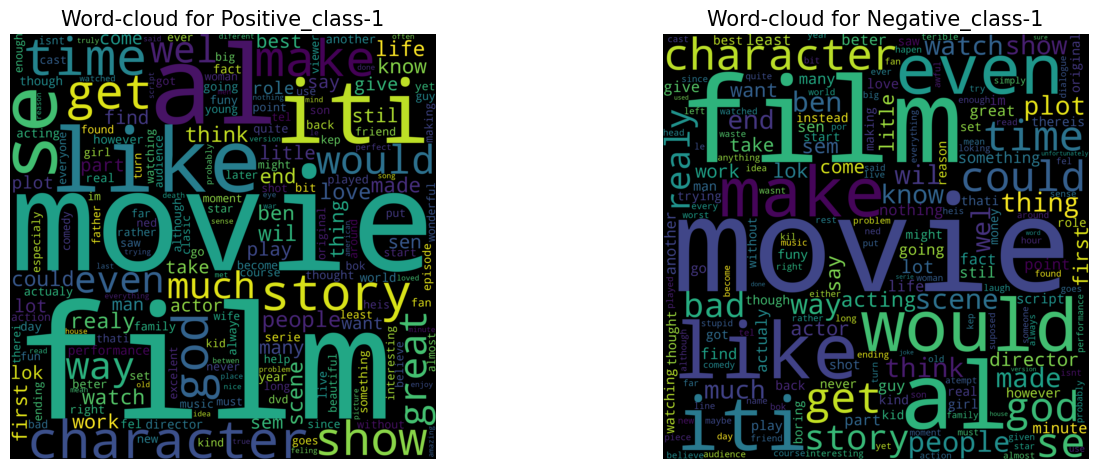

Positive  Negative
film       1.00      0.77
movie      0.95      1.00
al         0.51      0.44
like       0.34      0.30
iti        0.33      0.27

In [155]:
# WordClouds per sentiment label
toxic_wordclouds = []

plt.figure(figsize=(20,10))
count = 1

# here we do not have multiple labels that would require the processing i've commented out, rather a single col with labels
#for col in train_df[labels].columns:
#    toxic_class_1 = train_df[train_df[col] == 1]['comment_text'].str.lower().astype('category').str.cat(sep=' ')
labels = []
for val in tqdm(data['sentiment'].unique()): 
    labels.append(val)  # so I certainly capture the order in which they are indeed parsed
    sentiment_label1 = data[data['sentiment'] == val]['clean_text'].str.lower().astype('category').str.cat(sep=' ')
    wordcloud = WordCloud(width=2000, height=2000, background_color ='black', margin=1, stopwords = stop_words,
                          ).generate(sentiment_label1)    
    toxic_wordclouds.append(wordcloud.words_)
    
    plt.subplot(2,3,count)  # this starts counting from 1, not zero (0)!!!
    plt.axis('off')
    plt.title("Word-cloud for "+val+"_class-1",fontsize=15)
    plt.tight_layout(pad=3)
    plt.imshow(wordcloud, interpolation='bilinear')
    count += 1 
plt.show()
    
toxic_wordclouds_df = pd.DataFrame(toxic_wordclouds).T.round(2).fillna(0)
toxic_wordclouds_df.columns = labels
toxic_wordclouds_df.head()


# how this works:
# - For each label, a word cloud is generated from the comments labeled as that class.
# - The word frequencies (wordcloud.words_) are extracted and stored in the list toxic_wordclouds.
# - When the list of dictionaries toxic_wordclouds is converted into a DataFrame, pandas aligns the keys (words) from each dictionary and uses them as column headers.
# - Through transposing, the DataFrame is constructed such that each row represents a word and each column represents a label.
# - If a word is not present in a particular label's dictionary, pandas fills that position with NaN, which is later replaced with 0.


In [157]:
for rev in data['clean_text']:
    if ' iti ' in rev or ' al ' in rev:
        print(rev)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



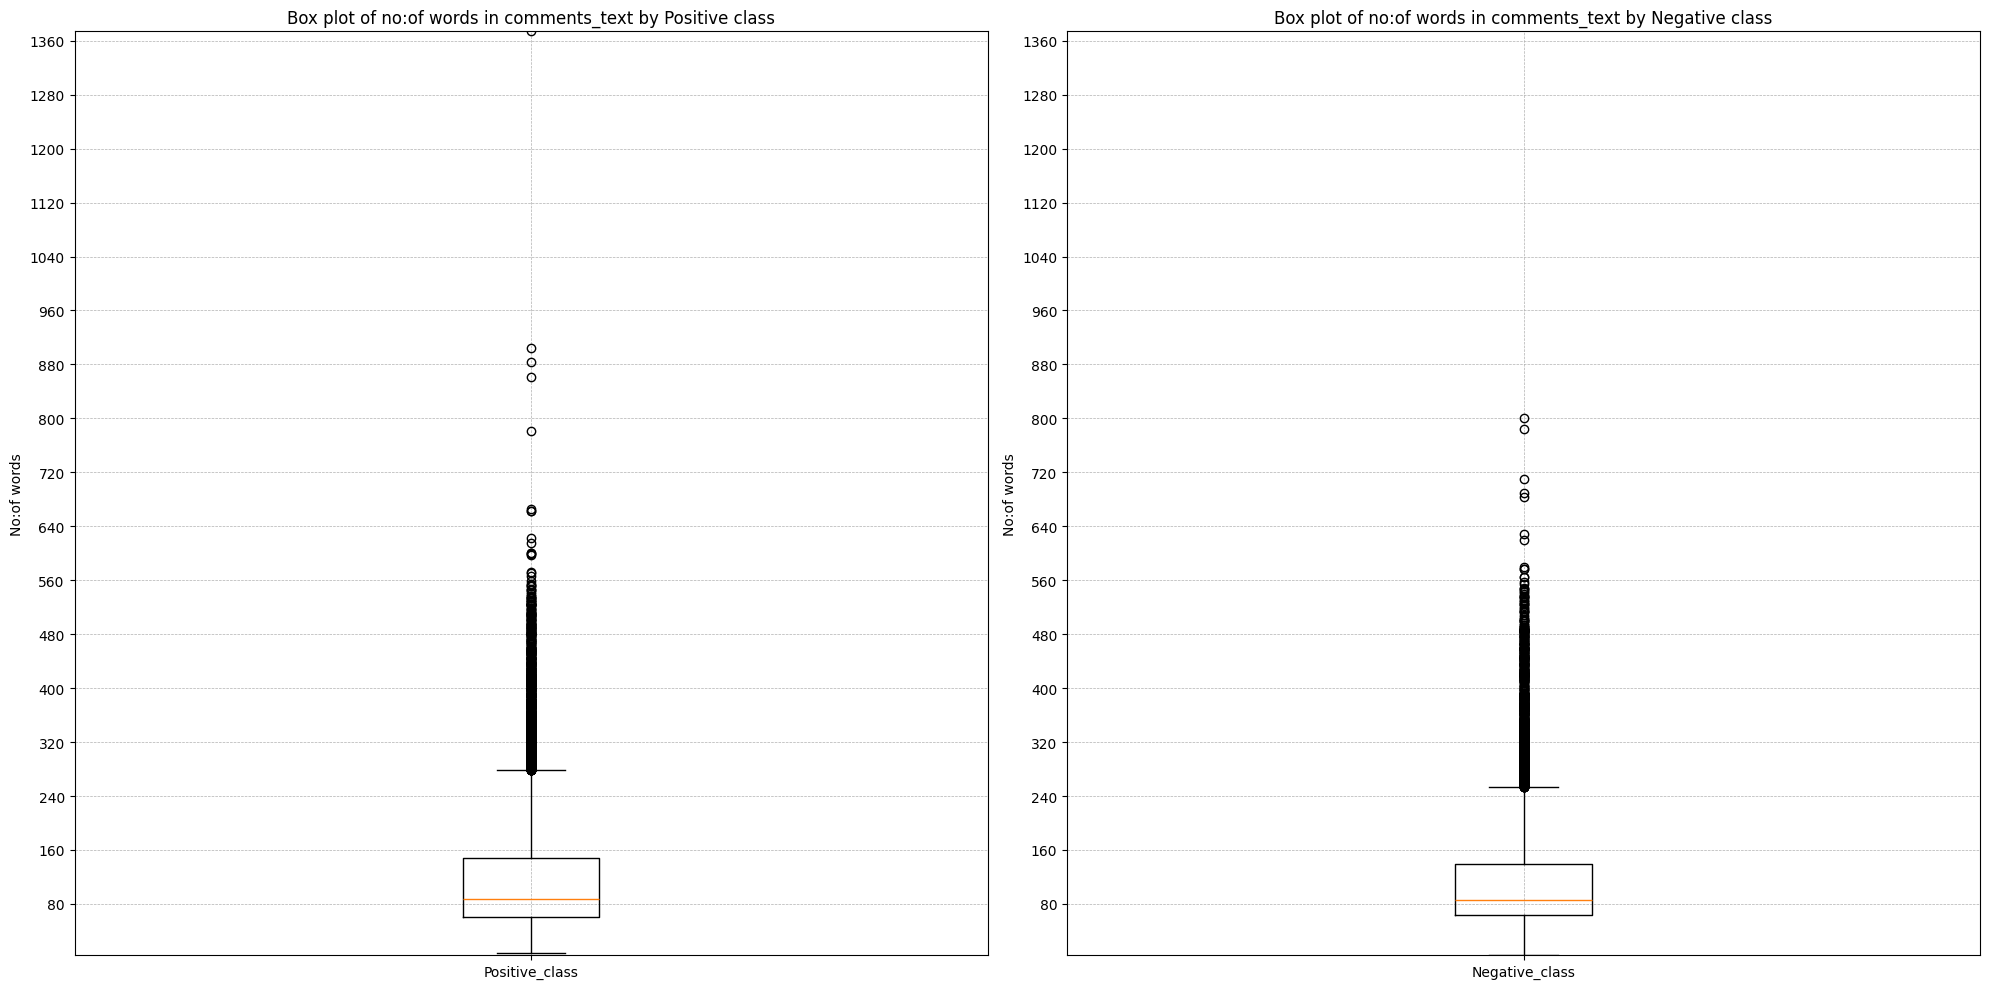

In [267]:
# Calculate the number of words in each review
data['word_count'] = data['clean_text'].str.split().apply(len)

# List of unique sentiment classes
sentiment_classes = data['sentiment'].unique()

# Determine the y-axis limits based on the entire dataset - i want the same y-ticks for both 
# plots to make comparisons more easily
y_min = data['word_count'].min()
y_max = data['word_count'].max()

# Create a boxplot for each sentiment class
plt.figure(figsize=(20, 10))
for i, sentiment in enumerate(sentiment_classes, 1):
    temp_class = data[data['sentiment'] == sentiment]['word_count']
    ax = plt.subplot(1, 2, i)
    plt.boxplot(temp_class)
    plt.title(f'Box plot of no:of words in comments_text by {sentiment} class')
    plt.xticks([1], [f'{sentiment}_class'])
    plt.ylim(y_min, y_max)  # Set the y-axis limits
    plt.ylabel('No:of words')
    plt.grid(True)

    # Setting major and minor grid lines for more density
    ax.yaxis.set_major_locator(plt.MaxNLocator(20))  # 10 major ticks
    ax.grid(which='both', linestyle='--', linewidth=0.5)  # Grid lines for both major and minor ticks


plt.tight_layout()
plt.show()


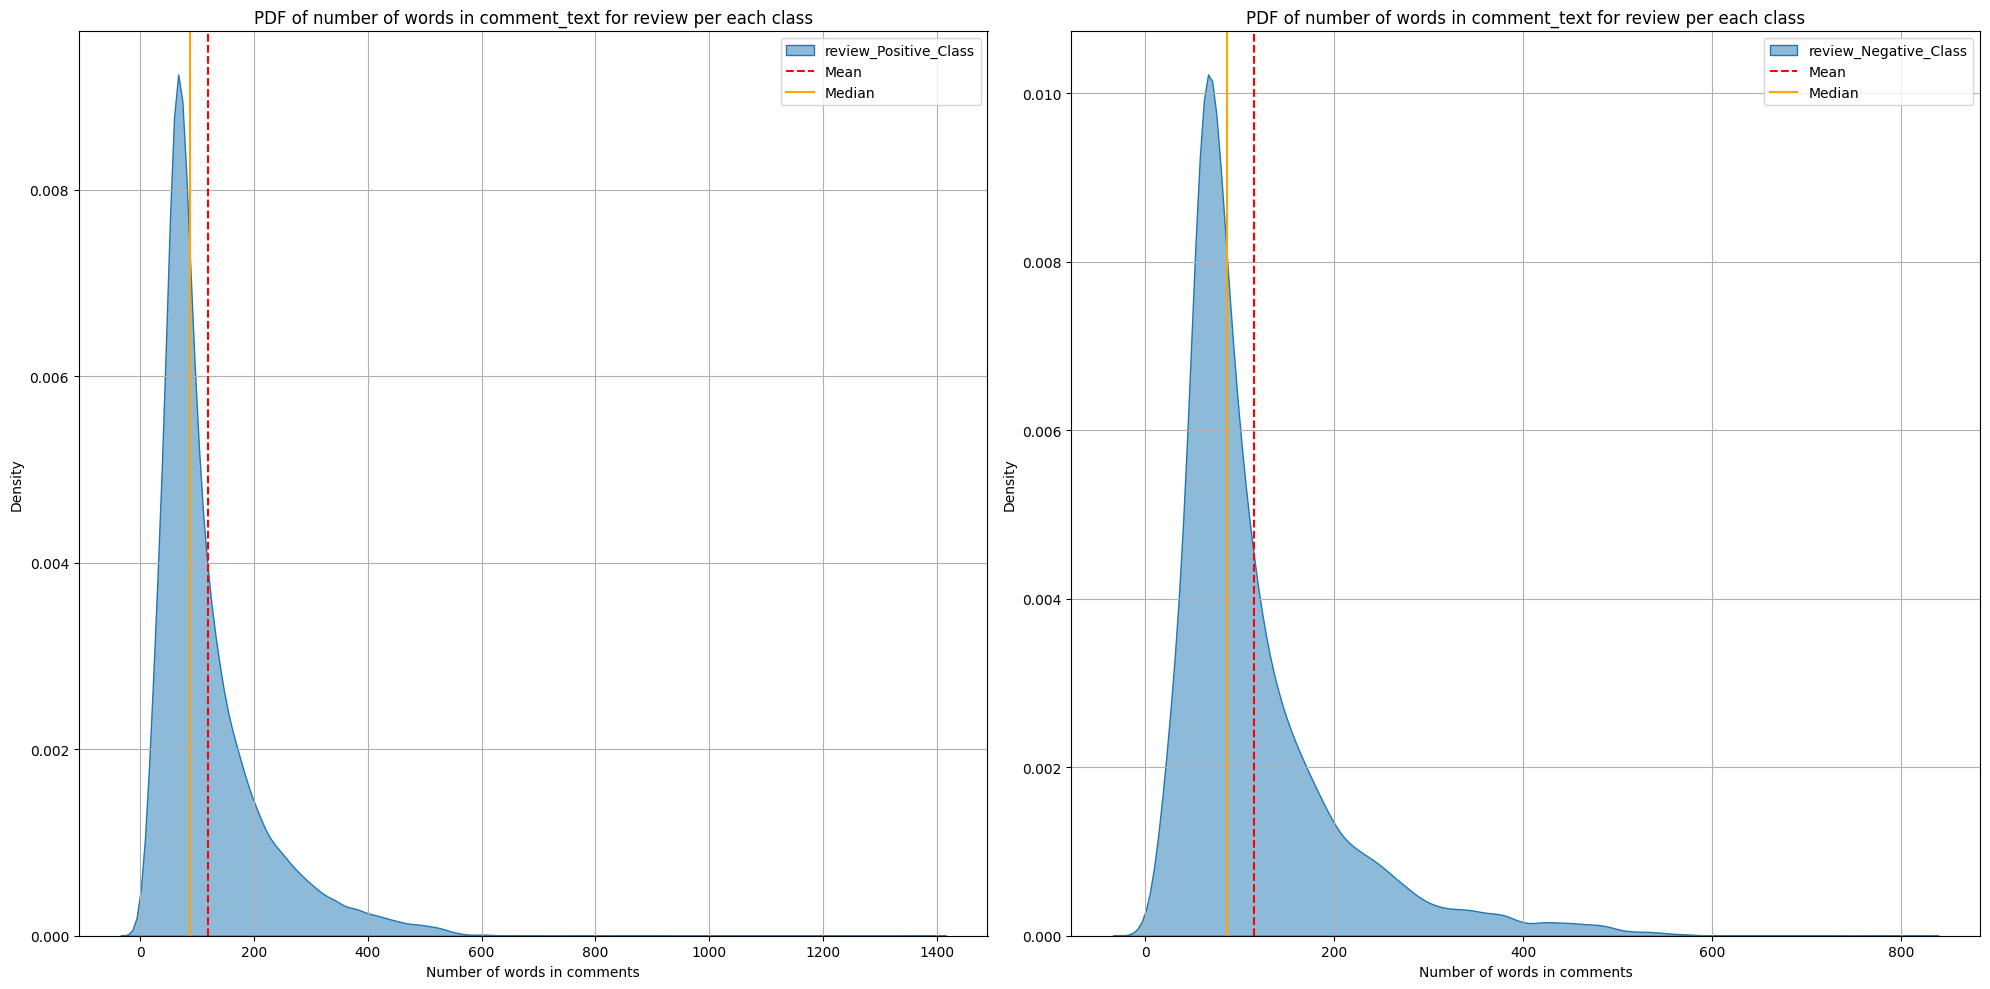

In [269]:
# Histograms

plt.figure(figsize=(20, 10))
count = 1

for i, sentiment in enumerate(sentiment_classes, 1):
    temp_class = data[data['sentiment'] == sentiment]['word_count']
    
    plt.subplot(1, 2, i)
    sns.kdeplot(temp_class, label=str(col)+f'_{sentiment}_Class', fill=True, common_norm=False, alpha=0.5)  # subplots are 1-indexed <> python lists
    plt.title('PDF of number of words in comment_text for '+str(col)+' per each class')
    plt.xlabel('Number of words in comments')
    plt.axvline(temp_class.mean(), color='red', linestyle='--', label='Mean')
    plt.axvline(temp_class.median(), color='orange', linestyle='-', label='Median')
    plt.legend()
    plt.grid()
    count += 1

plt.tight_layout()
plt.show()

In [8]:
X = pd.DataFrame(data['clean_text'], columns=['clean_text'])
y = data['sentiment']

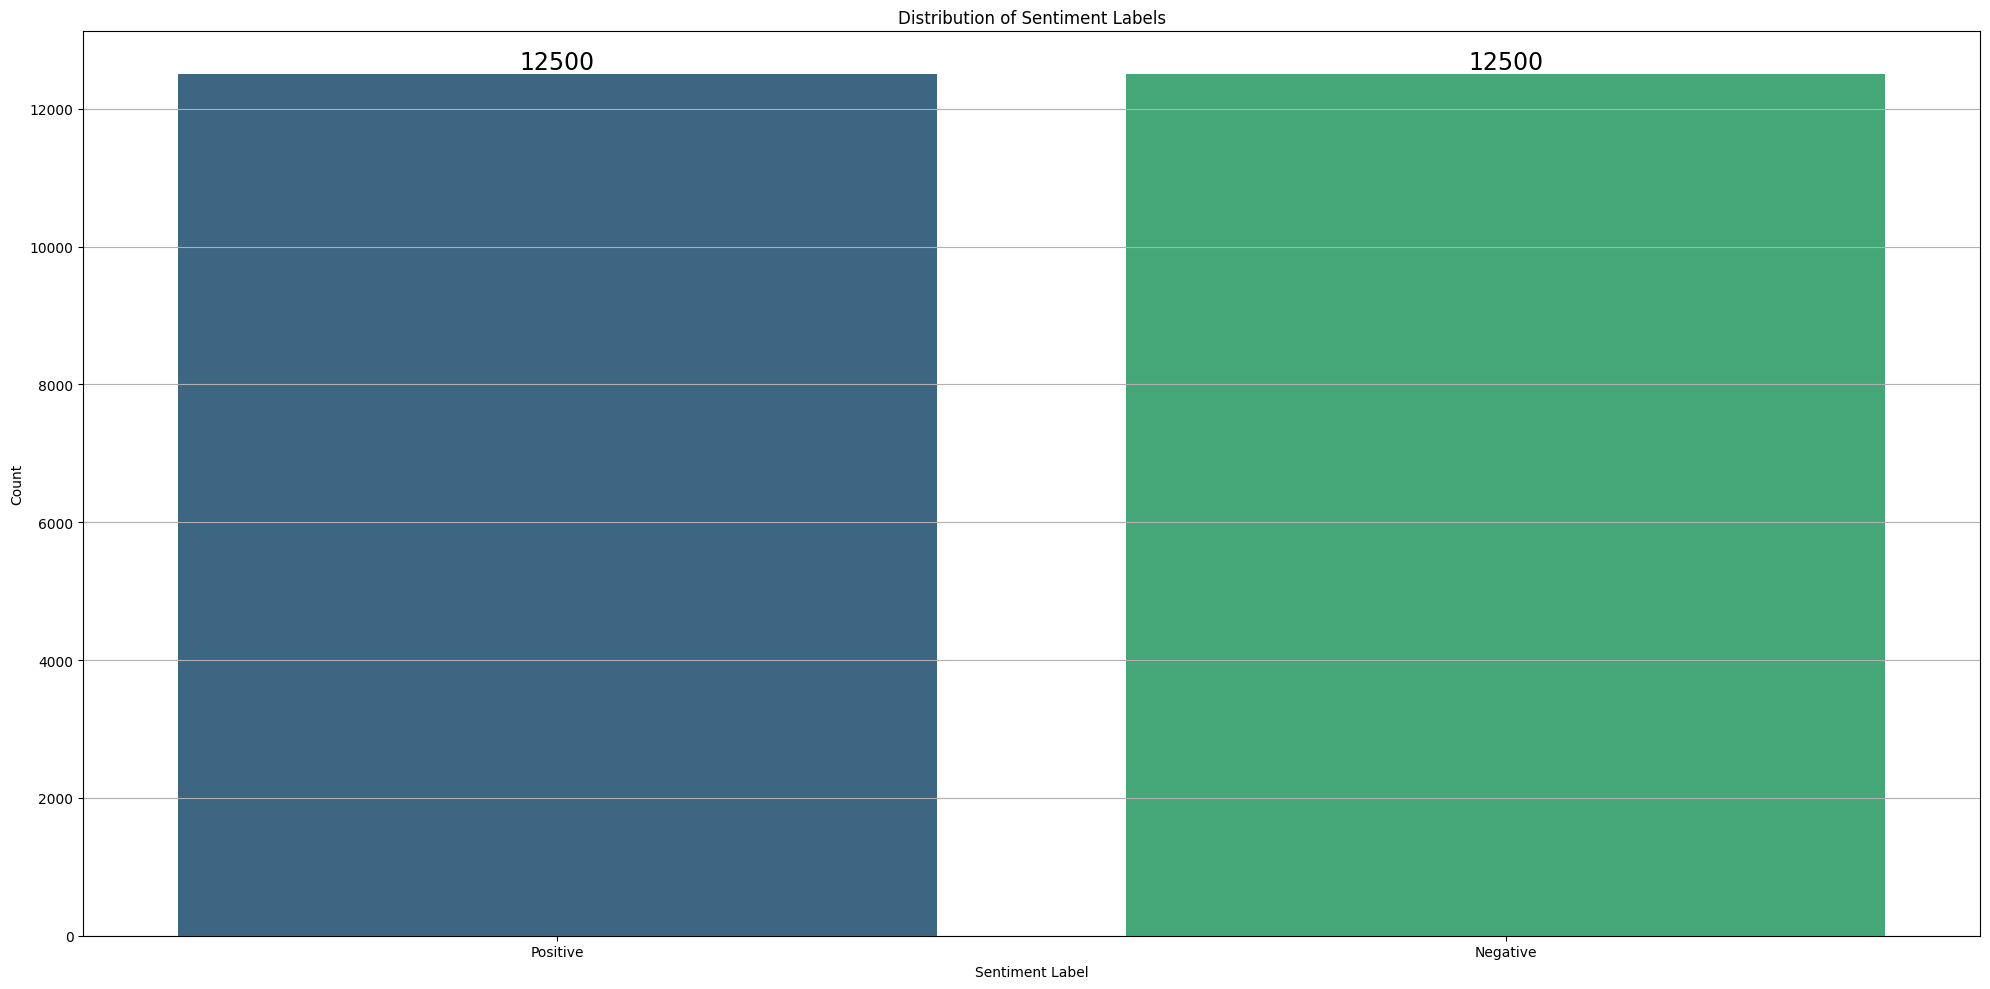

In [309]:
## Comparing the distribution of the two labels
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(x='sentiment', data=data, ax=ax, palette="viridis")
ax.set_title('Distribution of Sentiment Labels')
ax.set_xlabel('Sentiment Label')
ax.bar_label(container=ax.containers[0], labels=y.value_counts(ascending=False), fontsize=17)
ax.set_ylabel('Count')
ax.grid(True, axis='y')

plt.tight_layout()
plt.show()

In [310]:
# perfect balance between the two classes, no need to take many measures to ensure that our training and test sets are
# well-balanced -> I will only do stratification in our train_test_splitting

In [57]:
# The values of 'y' are strings so i perform label encoding: 
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['sentiment'])


In [58]:
### Split into train and test 
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

In [59]:
X_train.shape, y_test.shape

((20000, 1), (5000,))

In [321]:
### Feature extraction - Text Vectorization
# I have extracted other features as part of the preprocessing to prevent any duplicate operations - here I only perform vectorization

In [328]:
# Tokenize the processed text
sentences = [nltk.word_tokenize(text) for text in X_train['clean_text']]
tokens = list(set([word for sent in sentences for word in sent]))



########################## OneHotEncoding ###############################

data = pd.DataFrame({'Category': tokens})
encoder = OneHotEncoder(sparse_output=False, dtype=int)
endoded_data = encoder.fit_transform(data)


In [330]:
encoded_df = pd.DataFrame(endoded_data, columns=tokens)


In [331]:
encoded_df

touristas  alberta  forman  raspberryefore  junis  agonizingly  \
0              0        0       0               0      0            0   
1              0        0       0               0      0            0   
2              0        0       0               0      0            0   
3              0        0       0               0      0            0   
4              0        0       0               0      0            0   
...          ...      ...     ...             ...    ...          ...   
64570          0        0       0               0      0            0   
64571          0        0       0               0      0            0   
64572          0        0       0               0      0            0   
64573          0        0       0               0      0            0   
64574          0        0       0               0      0            0   

       marcelis  mediterranean  grizzled  dodgeball  ...  localis  dia  \
0             0              0         0          0  ...        0    0   
1             0              0         0          0  ...        0    0   
2             0              0         0          0  ...        0    0   
3             0              0         0          0  ...        0    0   
4             0              0         0          0  ...        0    0   
...         ...            ...       ...        ...  ...      ...  ...   
64570         0              0         0          0  ...        0    0   
64571         0              0         0          0  ...        0    0   
64572         0              0         0          0  ...        0    0   
64573         0              0         0          0  ...        0    0   
64574         0              0         0          0  ...        0    0   

       relationship  marney  ferilli  forsyth  tysonis  horneris  dicky  \
0                 0       0        0        0        0         0      0   
1                 0       0        0        0        0         0      0   
2                 0       0        0        0        0         0      0   
3                 0       0        0        0        0         0      0   
4                 0       0        0        0        0         0      0   
...             ...     ...      ...      ...      ...       ...    ...   
64570             0       0        0        0        0         0      0   
64571             0       0        0        0        0         0      0   
64572             0       0        0        0        0         0      0   
64573             0       0        0        0        0         0      0   
64574             0       0        0        0        0         0      0   

       buddhism  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
64570         0  
64571         0  
64572         0  
64573         0  
64574         0  

[64575 rows x 64575 columns]

In [ ]:
test_sentences = [nltk.word_tokenize(text) for text in X_test['clean_text']]
test_tokens = list(set([word for sent in test_sentences for word in sent]))

encoder.fit(test_tokens)

In [ ]:
########################## Bag-of-Words Vectorizer ##########################
# Custom tokenizer that does nothing because text is already preprocessed
def dummy_tokenizer(text):
    return text.split()

# Initialize CountVectorizer
vectorizer = CountVectorizer(tokenizer=dummy_tokenizer, preprocessor=lambda x: x, lowercase=False)

# Transform the processed text into a document-term matrix
bow_vectors = vectorizer.fit_transform(X_train['clean_text'])

# Convert the matrix to a DataFrame for better visualization
count_df = pd.DataFrame(bow_vectors.toarray(), columns=vectorizer.get_feature_names_out())

# Display the DataFrame
print(count_df)

tsne = TSNE(n_components=2, perplexity=2, init="random", random_state=42)
bow_embedded = tsne.fit_transform(bow_vectors)

# Plot the t-SNE visualization in a scatterplot; use tfidf_embedded 
# Optionally, use text annotations in the plot 

plt.figure(figsize=(8, 5))
plt.scatter(bow_embedded[:, 0], bow_embedded[:, 1])

for i, txt in enumerate(documents):
    plt.annotate(txt, (bow_embedded[i, 0], bow_embedded[i, 1]))
    
plt.title('t-SNE Visualization of BOW Vectors')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()



/Users/chkapsalis/miniconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


        Angel  Crying  Frown  Happy  Joyful  JoyfulHappy  Surprise  Tongue  \
0      0      0       0      0      0       0            0         0       0   
1      0      0       0      0      0       0            0         0       0   
2      0      0       0      0      0       0            0         0       0   
3      0      0       0      0      0       0            0         0       0   
4      0      0       0      0      0       0            0         0       0   
...   ..    ...     ...    ...    ...     ...          ...       ...     ...   
19995  0      0       0      0      0       0            0         0       0   
19996  0      0       0      0      0       0            0         0       0   
19997  0      0       0      0      0       0            0         0       0   
19998  0      0       0      0      0       0            0         0       0   
19999  0      0       0      0      0       0            0         0       0   

       Very  ...  êxtase  ísnt  østbye  ü

In [61]:
########################## TF-IDF Vectorizer ##########################
# Custom tokenizer that does nothing because text is already preprocessed
def dummy_tokenizer(text):
    return text.split()

# Vectorize the text using TfIdfVectorizer
vectorizer = TfidfVectorizer(tokenizer=dummy_tokenizer, preprocessor=lambda x: x, lowercase=False)
X_train_tfidf = vectorizer.fit_transform(X_train['clean_text'])  # processed text is just X_train['processed_text'] - a list of strings, not a list of lists
#X_train_tfidf_df = pd.DataFrame(tfidf_vectors.toarray(), columns=vectorizer.get_feature_names_out())

train_tokens = list(set([word for sent in X_train['clean_text'] for word in sent.split()]))


/Users/chkapsalis/miniconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [62]:
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
X_test_tfidf = vectorizer.transform(X_test['clean_text'])
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

In [74]:
# to use these df's together with other features I have previously extracted, I would just concatenate them with the df's containing the 
# corresponding info for each row (indexes have not been jammed anywhere in the process so that's safe)

  own  Angel  Crying  Frown  Happy  Joyful  JoyfulHappy  Surprise  \
0     0.0   0.0    0.0     0.0    0.0    0.0     0.0          0.0       0.0   
1     0.0   0.0    0.0     0.0    0.0    0.0     0.0          0.0       0.0   
2     0.0   0.0    0.0     0.0    0.0    0.0     0.0          0.0       0.0   
3     0.0   0.0    0.0     0.0    0.0    0.0     0.0          0.0       0.0   
4     0.0   0.0    0.0     0.0    0.0    0.0     0.0          0.0       0.0   
...   ...   ...    ...     ...    ...    ...     ...          ...       ...   
4995  0.0   0.0    0.0     0.0    0.0    0.0     0.0          0.0       0.0   
4996  0.0   0.0    0.0     0.0    0.0    0.0     0.0          0.0       0.0   
4997  0.0   0.0    0.0     0.0    0.0    0.0     0.0          0.0       0.0   
4998  0.0   0.0    0.0     0.0    0.0    0.0     0.0          0.0       0.0   
4999  0.0   0.0    0.0     0.0    0.0    0.0     0.0          0.0       0.0   

      Surprisenly  ...  êxtase  ísnt  østbye  über  üvegtigris    –    ’  \
0             0.0  ...     0.0   0.0     0.0   0.0         0.0  0.0  0.0   
1             0.0  ...     0.0   0.0     0.0   0.0         0.0  0.0  0.0   
2             0.0  ...     0.0   0.0     0.0   0.0         0.0  0.0  0.0   
3             0.0  ...     0.0   0.0     0.0   0.0         0.0  0.0  0.0   
4             0.0  ...     0.0   0.0     0.0   0.0         0.0  0.0  0.0   
...           ...  ...     ...   ...     ...   ...         ...  ...  ...   
4995          0.0  ...     0.0   0.0     0.0   0.0         0.0  0.0  0.0   
4996          0.0  ...     0.0   0.0     0.0   0.0         0.0  0.0  0.0   
4997          0.0  ...     0.0   0.0     0.0   0.0         0.0  0.0  0.0   
4998          0.0  ...     0.0   0.0     0.0   0.0         0.0  0.0  0.0   
4999          0.0  ...     0.0   0.0     0.0   0.0         0.0  0.0  0.0   

      …although    ₤      
0           0.0  0.0  0.0  
1           0.0  0.0  0.0  
2           0.0  0.0  0.0  
3           0.0  0.0  0.0  
4           0.0  0.0  0.0  
...         ...  ...  ...  
4995        0.0  0.0  0.0  
4996        0.0  0.0  0.0  
4997        0.0  0.0  0.0  
4998        0.0  0.0  0.0  
4999        0.0  0.0  0.0  

[5000 rows x 65002 columns]

In [111]:
words_tfidf = vectorizer.get_feature_names_out()

# required because 'pca' serialization is not available with sparse matrices
X_train_tfidf_dense = np.asarray(X_train_tfidf.todense())

### Dimensionality reduction with T-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=10, init='random')
tsne_res_tfidf = pd.DataFrame(tsne.fit_transform(X_train_tfidf_dense), columns=['tsne1', 'tsne2'])
tsne_res_tfidf['word'] = words_tfidf

# Print the tsne results
print(tsne_res_tfidf)

# Create the scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne1', y='tsne2', data=tsne_res_tfidf)

# Annotate the scatter plot with the words
for i, word in enumerate(tsne_res_tfidf['word']):
    plt.annotate(word, (tsne_res_tfidf['tsne1'][i], tsne_res_tfidf['tsne2'][i]), fontsize=12)

plt.title('TSNE of Word2Vec Vectors')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()





KeyboardInterrupt: 

In [113]:

### Dimensionality reduction with pca
pca = PCA(n_components=2)


# required because 'pca' serialization is not available with sparse matrices
X_train_tfidf_dense = np.asarray(X_train_tfidf.todense())

pca_scores_tfidf = pd.DataFrame(pca.fit_transform(X_train_tfidf_dense), columns=['PC1','PC2'])
pca_scores_tfidf['word'] = words
print(pca_scores_tfidf)

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_scores_tfidf)

for i, word in enumerate(pca_scores_tfidf['word']):
    plt.annotate(word, (pca_scores_tfidf['PC1'][i], pca_scores_tfidf['PC2'][i]), fontsize=12)

plt.title('PCA of Word2Vec Vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

KeyboardInterrupt: 

In [ ]:
########################## N-Gram Features ##########################
# Custom tokenizer that does nothing because text is already preprocessed
def dummy_tokenizer(text):
    return text.split()



ngram_vectorizer = CountVectorizer(ngram_range=(2,3), tokenizer=dummy_tokenizer, preprocessor=lambda x: x, lowercase=False)
train_ngram_vectors = ngram_vectorizer.fit_transform(X_train['clean_text'])
train_ngram_df = pd.DataFrame(train_ngram_vectors.toarray(), columns=ngram_vectorizer.get_feature_names_out())
test_ngram_vectors = ngram_vectorizer.transform(X_test['clean_text'])
test_ngram_df = pd.DataFrame(test_ngram_vectors.toarray(), columns=ngram_vectorizer.get_feature_names_out())
# Display the DataFrame
print(train_ngram_df)

words_ng = ngram_vectorizer.get_feature_names_out()

tsne_ng = TSNE(n_components=2, perplexity=2, init="random", random_state=42)

# required because 'pca' serialization is not available with sparse matrices
X_train_tfidf_dense = np.asarray(X_train_tfidf.todense())

ngram_embedded = tsne_ng.fit_transform(X_train_tfidf_dense)  # or train_ngram_vectors

# Plot the t-SNE visualization in a scatterplot; use tfidf_embedded 
# Optionally, use text annotations in the plot 

plt.figure(figsize=(8, 5))
plt.scatter(ngram_embedded[:, 0], ngram_embedded[:, 1])

for i, txt in enumerate(words_ng):
    plt.annotate(txt, (ngram_embedded[i, 0], ngram_embedded[i, 1]))
    
plt.title('t-SNE Visualization of N-Gram Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()





In [102]:
########################## Word2Vec ###############################
# Train Word2Vec model
# w2v expects a list of tokenized sentences
sentences = [doc.split() for doc in data['clean_text']]
vector_size = 100
w2v = Word2Vec(sentences, vector_size=vector_size, window=5, min_count=1)

def get_mean_embedding_vector(doc, model):
    words = doc.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)
train = X_train.copy()
test = X_test.copy()

train['vector'] = train['clean_text'].apply(lambda x: get_mean_embedding_vector(x, w2v))
test['vector'] = test['clean_text'].apply(lambda x: get_mean_embedding_vector(x, w2v))

print(train[['clean_text', 'vector']])

# List the vocabulary words from w2v.wv  
words = list(w2v.wv.key_to_index.keys())

# Retrieve all the word vectors of all the words in the corpus and store in a new variable "word_vectors"
word_vectors = np.array([w2v.wv[word] for word in words])








                                              clean_text  \
14523  letis set thing straight movie seek redefine g...   
21396  seem type review film net hate curse ralph bak...   
13461  thereis nothing new standard romantic comedy s...   
637    fan silent film look forward see picture first...   
16653  francis ford coppola brain aneurysm time direc...   
...                                                  ...   
17708  get question thought idea make think make seco...   
7636   tell truth ’ bit stun see positive review many...   
11269  every kid movie pop vhs nothing babysitter aro...   
12408  understand make remake become trend every rema...   
23248  really like show readily see achieve cult stat...   

                                                  vector  
14523  [-0.09002402, 0.32914248, 0.044068564, 0.03626...  
21396  [-0.101049215, 0.01975566, -0.18418653, 0.1373...  
13461  [0.091883644, 0.16117811, 0.011605963, -0.0148...  
637    [-0.114194214, 0.4132689, 0.00652913

In [103]:
# to be able to use both the vector as well as another features I extract from before, I will turn the 'vector' feature, which holds 
# values that constitute lists of length 'vector_size', into 'vector_size' equivalent features, dropping the 'vector' column
# and concatenating the result with the df containing my other features 

In [104]:
# Split the vector into separate features
vector_size=100
vector_columns = [f'w2v_vector_{i}' for i in range(vector_size)]
train[vector_columns] = pd.DataFrame(train['vector'].tolist(), index=train.index)  # keep the indexes, because I am going to concat/merge
test[vector_columns] = pd.DataFrame(test['vector'].tolist(), index=test.index)

# Drop the original 'vector' column
train.drop(columns=['vector', 'clean_text'], inplace=True)
test.drop(columns=['vector', 'clean_text'], inplace=True)

# example extra feature - it would be numeric anyways, since most of the algorithms' implementations we see require strictly numeric input
train['extra_feature'] = 0
test['extra_feature'] = 0

# Now train and test DataFrames have separate vector features
#print(train[vector_columns].head())
#print(test[vector_columns].head())

# Extract feature columns
X_train2 = train[vector_columns+['extra_feature']]
X_test2 = test[vector_columns+['extra_feature']]
print('Shape of new X_xxx dfs:', X_train2.shape, X_test2.shape)

# Example training with Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(solver='liblinear')
lr.fit(X_train2, y_train)
predictions = lr.predict(X_test2)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy =", accuracy)


/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_19656/615810902.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[vector_columns] = pd.DataFrame(train['vector'].tolist(), index=train.index)  # keep the indexes, because I am going to concat/merge
/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_19656/615810902.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[vector_columns] = pd.DataFrame(test['vector'].tolist(), index=test.index)
/var/folders/fp/b19fbw2j41z9_lyxq1cyd88h0000gn/T/ipykernel_1965

Shape of new X_xxx dfs: (20000, 101) (5000, 101)
Accuracy = 0.8472


           tsne1      tsne2        word
0      85.761192 -26.207649       movie
1      85.801529 -26.232527        film
2      80.271408 -30.036110        make
3      85.385742 -25.296526        like
4      82.939522 -26.811506         see
...          ...        ...         ...
71636 -57.051376 -36.684383         mhm
71637   0.295155 -23.994377     cribbed
71638 -64.875488  11.782505   hersheyis
71639 -51.633163 -12.599060     loveday
71640 -36.980625 -21.611664  unfairness

[71641 rows x 3 columns]


/Users/chkapsalis/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chkapsalis/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 151 (\x97) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chkapsalis/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 142 (\x8e) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chkapsalis/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 149 (\x95) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chkapsalis/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 158 (\x9e) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chkapsalis/mi

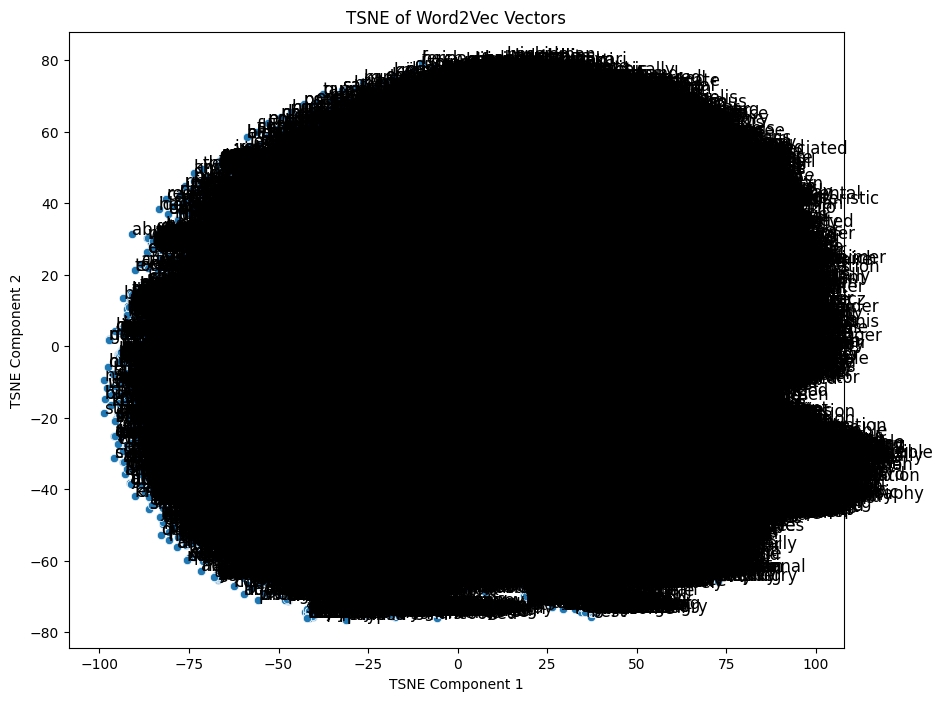

            PC1       PC2        word
0      2.154204  7.176971       movie
1      2.175794  6.176915        film
2      2.224491  4.953237        make
3      2.327244  3.148242        like
4      2.218845  4.601639         see
...         ...       ...         ...
71636 -0.428351  0.095136         mhm
71637 -0.379233  0.027114     cribbed
71638 -0.429555  0.005873   hersheyis
71639 -0.394192  0.049498     loveday
71640 -0.432620  0.061541  unfairness

[71641 rows x 3 columns]


/Users/chkapsalis/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chkapsalis/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 151 (\x97) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chkapsalis/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 142 (\x8e) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chkapsalis/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 149 (\x95) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chkapsalis/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 158 (\x9e) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chkapsalis/mi

KeyboardInterrupt: 

In [106]:
### Dimensionality reduction with T-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_res = pd.DataFrame(tsne.fit_transform(word_vectors), columns=['tsne1', 'tsne2'])
tsne_res['word'] = words

# Print the tsne results
print(tsne_res)

# Create the scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne1', y='tsne2', data=tsne_res)

# Annotate the scatter plot with the words
for i, word in enumerate(tsne_res['word']):
    plt.annotate(word, (tsne_res['tsne1'][i], tsne_res['tsne2'][i]), fontsize=12)

plt.title('TSNE of Word2Vec Vectors')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()




### Dimensionality reduction with pca
pca = PCA(n_components=2)
pca_scores = pd.DataFrame(pca.fit_transform(word_vectors), columns=['PC1','PC2'])
pca_scores['word'] = words
print(pca_scores)

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_scores)

for i, word in enumerate(pca_scores['word']):
    plt.annotate(word, (pca_scores['PC1'][i], pca_scores['PC2'][i]), fontsize=12)

plt.title('PCA of Word2Vec Vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
### Predictive models

In [63]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

lr = LogisticRegression(penalty='l2', C = 4, max_iter=10000)
lr.fit(X_train_tfidf, y_train)

LogisticRegression(C=4, max_iter=10000)

In [64]:
X_test_tfidf.shape, y_test.shape

((5000, 65002), (5000,))

In [65]:
# Use the multilabel_clf to predict X_test_tfidf. Save the results in 'y_test_pred' 
y_test_pred = lr.predict(X_test_tfidf)

In [66]:
y_test_pred

array([1, 1, 1, ..., 0, 1, 0])

In [68]:
# this is expected to be done only in multi-label classification scenarios
#mo_probs = lr.predict_proba(X_test_tfidf)

#n_classes = 2
#n_test_samples = X_test_tfidf.shape[0]
#mo_probs_pos = np.zeros((n_test_samples, n_classes))

#for c in range(n_classes):
#    c_probs = mo_probs[c]
#    mo_probs_pos[:, c] = c_probs[:, 1]

#pd.DataFrame(mo_probs_pos, columns=labels)

In [69]:
# Print the overall accuracy using the accuracy_score() function by passing y_test and y_test_pred 

accuracy_score(y_test, y_test_pred)

0.8898

In [70]:
# Print the Hamming loss using the hamming_loss() function by passing y_test and y_test_pred 

hamming_loss(y_test, y_test_pred)

0.1102

In [49]:
# only for multilabel classification scenarios
#confusion_mat = confusion_matrix(y_test.argmax(axis=1), y_test_pred.argmax(axis=1))
#confusion_mat

In [51]:
#plt.subplots(figsize=(10,6))
#sns.heatmap(confusion_mat, annot=True, fmt='.5g')
#plt.xlabel('Predicted')
#plt.ylabel('Actual');

In [55]:
# using classifier chains - this is for multilabel scenarios as well
#from sklearn.multioutput import ClassifierChain
# from skmultilearn.problem_transform import ClassifierChain
#from sklearn.linear_model import LogisticRegression

#classifier chain 
#chain = ClassifierChain(LogisticRegression(solver='liblinear'))
#chain.fit(X_train_tfidf, y_train) 
#predictions = chain.predict(X_test_tfidf)

# accuracy
#print("Accuracy = ",accuracy_score(y_test,predictions))
#print("\n")